In [14]:
import sys

# New Section

In [15]:
# To add your own Drive Run this cell.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Please append your own directory after ‘/content/drive/My Drive/'
# where you have nutil.py and adult_subsample.csv
### ========== TODO : START ========== ###
sys.path += ['/content/drive/My Drive/CM146_PSet'] # path
#sys.path += ['/content/drive/'] # example path

### ========== TODO : END ========== ###

In [17]:
from nutil import *

In [18]:
# Use only the provided packages!
import math
import csv

from collections import Counter

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [19]:
######################################################################
# Immutable classes
######################################################################

class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y



In [20]:
######################################################################
# Mutable classes
######################################################################

class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO : START ========== ###
        # part b: set self.probabilities_ according to the training set
        labels = [0.0,0.0]
        for i in y:
         labels[int(i)]+=1.0
        class_counts = Counter(y)
        total_samples = len(y)
        labels[0] = labels[0]/total_samples
        labels[1] = labels[1]/total_samples
        self.probabilities_ = labels
        ### ========== TODO : END ========== ###
        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO : START ========== ###
        # part b: predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        n, d = X.shape
        y = np.random.choice(len(self.probabilities_), n, p=self.probabilities_)
        ### ========== TODO : END ========== ###
        return y


In [21]:
######################################################################
# Immutable functions
######################################################################

def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,15))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend() #plt.legend(loc='upper left')
        plt.show()

    return data, bins, align, labels


In [22]:
######################################################################
# Mutable functions
######################################################################

def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO : START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    total_train_error = 0
    total_test_error = 0
    total_f1_score = 0

    # StratifiedShuffleSplit for random splits
    sss = StratifiedShuffleSplit(n_splits=ntrials, test_size=test_size, random_state=0)

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the classifier
        clf.fit(X_train, y_train)

        # Make predictions on training and testing sets
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)

        # Compute errors and f1 score for each trial
        train_error = 1 - metrics.accuracy_score(y_train, y_train_pred)
        test_error = 1 - metrics.accuracy_score(y_test, y_test_pred)
        f1 = metrics.f1_score(y_test, y_test_pred, average='micro')

        # Accumulate errors and f1 scores
        total_train_error += train_error
        total_test_error += test_error
        total_f1_score += f1

    # Average errors and f1 scores over trials
    train_error = total_train_error / ntrials
    test_error = total_test_error / ntrials
    f1_score = total_f1_score / ntrials

    ### ========== TODO : END ========== ###

    return train_error, test_error, f1_score




In [23]:
######################################################################
# Immutable functions
######################################################################


def write_predictions(y_pred, filename, yname=None) :
    """Write out predictions to csv file."""
    out = open(filename, 'wb')
    f = csv.writer(out)
    if yname :
        f.writerow([yname])
    f.writerows(list(zip(y_pred)))
    out.close()


Classifying using Majority Vote...
	-- training error: 0.240
Classifying using Random...
	-- training error: 0.374
Classifying using Decision Tree...
	-- training error: 0.000
Classifying using k-Nearest Neighbors...
	-- training error (k=3): 0.114
	-- training error (k=5): 0.129
	-- training error (k=7): 0.152
Investigating various classifiers...
MajorityVoteClassifier: train_error = 0.240
MajorityVoteClassifier: test_error = 0.240
MajorityVoteClassifier: f1_score = 0.760
-------------
RandomClassifier: train_error = 0.375
RandomClassifier: test_error = 0.382
RandomClassifier: f1_score = 0.618
-------------
DecisionTreeClassifier: train_error = 0.000
DecisionTreeClassifier: test_error = 0.205
DecisionTreeClassifier: f1_score = 0.795
-------------
KNeighborsClassifier: train_error = 0.133
KNeighborsClassifier: test_error = 0.209
KNeighborsClassifier: f1_score = 0.791
-------------
Finding the best k...
Best value of k 27


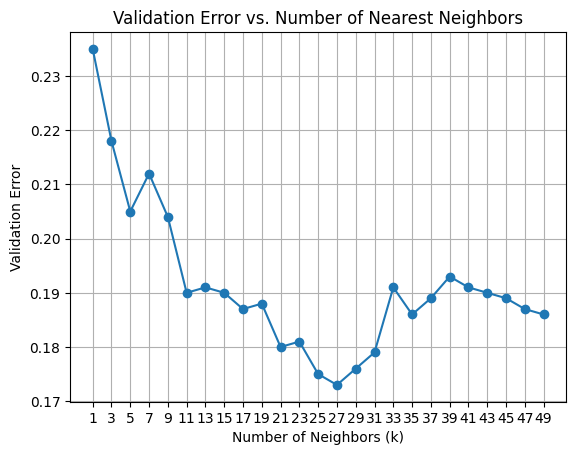

Investigating depths...
Best max depth value for minimum test error: 5
Best max depth value for minimum training error: 20


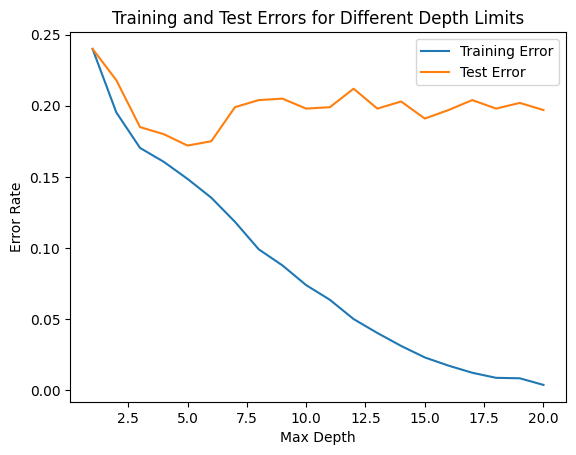

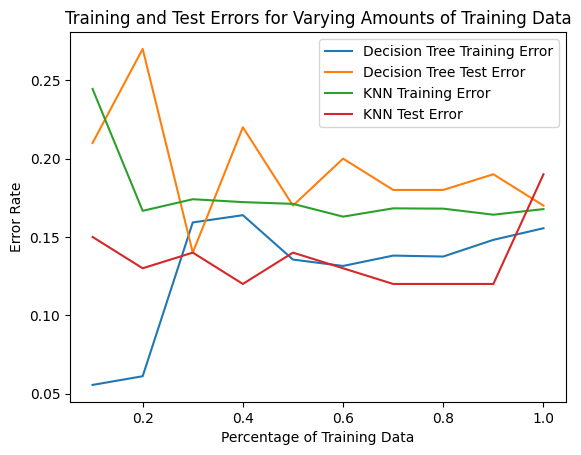

Done


In [28]:

######################################################################
# main
######################################################################

def main():



    # load adult_subsample dataset with correct file path
    ### ========== TODO : START ========== ###
    #data_file =  "/content/drive/My Drive/cm146-2024-homeowrks/PS1/adult_subsample.csv" # example path
    data_file =  "/content/drive/My Drive/CM146_PSet/adult_subsample.csv" # your path
    ### ========== TODO : END ========== ###


    data = load_data(data_file, header=1, predict_col=-1)

    X = data.X; Xnames = data.Xnames
    y = data.y; yname = data.yname
    n,d = X.shape  # n = number of examples, d =  number of features



    #========================================
    # part a: plot histograms of each feature
    '''print('Plotting...')
    plot_histograms (X, y, Xnames=Xnames, yname=yname)
    plt.show()'''



    ### ========== TODO : START ========== ###
    # part i: Preprocess X (e.g., normalize)
    # (try this after finishing the sections below)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    ### ========== TODO : END ========== ###




    #========================================
    # train Majority Vote classifier on data
    print('Classifying using Majority Vote...')
    clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
    clf.fit(X, y)                  # fit training data using the classifier
    y_pred = clf.predict(X)        # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)





    ### ========== TODO : START ========== ###
    # part b: evaluate training error of Random classifier
    print('Classifying using Random...')
    clf2 = RandomClassifier() # create RandomClassifier, which includes all model parameters
    clf2.fit(X,y)              # fit training data using the classifier
    y_pred = clf2.predict(X)   # take the classifier and run it on the training data
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part c: evaluate training error of Decision Tree classifier
    print('Classifying using Decision Tree...')
    clf3 = DecisionTreeClassifier(criterion="entropy").fit(X,y)
    y_pred = clf3.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error: %.3f' % train_error)

    # print('\t-- training error: %.3f' % train_error)
    ### ========== TODO : END ========== ###


    ### ========== TODO : START ========== ###
    # part d: evaluate training error of k-Nearest Neighbors classifier
    # use k = 3, 5, 7 for n_neighbors
    print('Classifying using k-Nearest Neighbors...')
    clf = KNeighborsClassifier(3).fit(X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error (k=3): %.3f' % train_error)

    clf = KNeighborsClassifier(5).fit(X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error (k=5): %.3f' % train_error)

    clf = KNeighborsClassifier(7).fit(X,y)
    y_pred = clf.predict(X)
    train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
    print('\t-- training error (k=7): %.3f' % train_error)
    # print the error for each k

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part e: use cross-validation to compute average training and test error of classifiers
    print('Investigating various classifiers...')

    clf = MajorityVoteClassifier()
    summary = error(clf, X, y, ntrials=100)
    print(f"MajorityVoteClassifier: train_error = {summary[0]:.3f}")
    print(f"MajorityVoteClassifier: test_error = {summary[1]:.3f}")
    print(f"MajorityVoteClassifier: f1_score = {summary[2]:.3f}")
    print("-------------")

    clf = RandomClassifier()
    summary = error(clf, X, y, ntrials=100)
    print(f"RandomClassifier: train_error = {summary[0]:.3f}")
    print(f"RandomClassifier: test_error = {summary[1]:.3f}")
    print(f"RandomClassifier: f1_score = {summary[2]:.3f}")
    print("-------------")

    clf = DecisionTreeClassifier(criterion="entropy")
    summary = error(clf, X, y, ntrials=100)
    print(f"DecisionTreeClassifier: train_error = {summary[0]:.3f}")
    print(f"DecisionTreeClassifier: test_error = {summary[1]:.3f}")
    print(f"DecisionTreeClassifier: f1_score = {summary[2]:.3f}")
    print("-------------")

    clf = KNeighborsClassifier(5)
    summary = error(clf, X, y, ntrials=100)
    print(f"KNeighborsClassifier: train_error = {summary[0]:.3f}")
    print(f"KNeighborsClassifier: test_error = {summary[1]:.3f}")
    print(f"KNeighborsClassifier: f1_score = {summary[2]:.3f}")
    print("-------------")

    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part f: use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
    print('Finding the best k...')
    k_values = list(range(1,51,2))
    cross_val_mean = []

    def test_error_scorer(clf, X, y):
      y_pred = clf.predict(X)
      return 1 - metrics.accuracy_score(y, y_pred, normalize=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    for k in k_values:
      knn = KNeighborsClassifier(n_neighbors=k)
      scores = cross_val_score(knn, X, y, cv=10) #removed scorer
      cross_val_mean.append(1-np.mean(scores))

    best_k = k_values[np.argmin(cross_val_mean)]
    print("Best value of k", best_k)

    plt.plot(k_values, cross_val_mean, marker='o')
    plt.title('Validation Error vs. Number of Nearest Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Validation Error')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()


    ### ========== TODO : END ========== ###




    ### ========== TODO : START ========== ###
    # part g: investigate decision tree classifier with various depths
    print('Investigating depths...')
    depth_vals = list(range(1,21))
    avg_train_error = []
    avg_test_error = []

    for depth_limit in depth_vals:
      clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth_limit)
      cv_result = cross_validate(clf, X, y, cv=10, return_train_score=True)

      train_error = 1 - np.mean(cv_result['train_score'])
      test_error = 1 - np.mean(cv_result['test_score'])

      avg_train_error.append(train_error)
      avg_test_error.append(test_error)

    best_test_depth = depth_vals[np.argmin(avg_test_error)]
    best_train_depth = depth_vals[np.argmin(avg_train_error)]
    print("Best max depth value for minimum test error:", best_test_depth)
    print("Best max depth value for minimum training error:", best_train_depth)

    plt.plot(depth_vals, avg_train_error, label='Training Error')
    plt.plot(depth_vals, avg_test_error, label='Test Error')
    plt.xlabel('Max Depth')
    plt.ylabel('Error Rate')
    plt.title('Training and Test Errors for Different Depth Limits')
    plt.legend()
    plt.show()

    ### ========== TODO : END ========== ###





    ### ========== TODO : START ========== ###
    # part h: investigate decision tree and k-Nearest Neighbors classifier with various training set sizes
    # hint: use train_test_split (use random_state=0 for consistent results)
    training_data_percentages = np.arange(0.1, 1, 0.1)

    best_depth_value = 5 #For decision tree
    best_k_value = 15 #For KNN

    dt_train_errors = []
    dt_test_errors = []

    knn_train_errors = []
    knn_test_errors = []

    #setting aside testing data
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.1, random_state=0)

    for training_data_percentage in training_data_percentages:

      X_train, X_test, y_train, y_test = train_test_split(X_train1, y_train1, train_size=training_data_percentage, random_state=0)

      #Decision Tree
      dt_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth_value)
      dt_classifier.fit(X_train, y_train) #fit it to the training set made by the current proportion of the 90%

      dt_train_pred = dt_classifier.predict(X_train) #get predictions on training data
      dt_test_pred = dt_classifier.predict(X_test1) #get predictions on main test data

      dt_train_error = 1 - metrics.accuracy_score(y_train, dt_train_pred, normalize=True)
      dt_test_error = 1 - metrics.accuracy_score(y_test1, dt_test_pred, normalize=True)

      dt_train_errors.append(dt_train_error)
      dt_test_errors.append(dt_test_error)

      #KNN Algorithm
      knn_classifier = KNeighborsClassifier(n_neighbors=best_k_value)
      knn_classifier.fit(X_train, y_train)

      knn_train_pred = knn_classifier.predict(X_train)
      knn_test_pred = knn_classifier.predict(X_test1)

      knn_train_error = 1 - metrics.accuracy_score(y_train, knn_train_pred, normalize=True)
      knn_test_error = 1 - metrics.accuracy_score(y_test1, knn_test_pred, normalize=True)

      knn_train_errors.append(knn_train_error)
      knn_test_errors.append(knn_test_error)

    #Training models on full 90% fraction
    dt_classifier = DecisionTreeClassifier(criterion="entropy", max_depth=best_depth_value)
    dt_classifier.fit(X_train1, y_train1)

    dt_train_pred = dt_classifier.predict(X_train1)
    dt_test_pred = dt_classifier.predict(X_test1)

    dt_train_error = 1 - metrics.accuracy_score(y_train1, dt_train_pred, normalize=True)
    dt_test_error = 1 - metrics.accuracy_score(y_test1, dt_test_pred, normalize=True)

    dt_train_errors.append(dt_train_error)
    dt_test_errors.append(dt_test_error)

    knn_classifier = KNeighborsClassifier(n_neighbors=best_k_value)
    knn_classifier.fit(X_train1, y_train1)

    knn_train_pred = knn_classifier.predict(X_train1)
    knn_test_pred = knn_classifier.predict(X_test1)

    knn_train_error = 1 - metrics.accuracy_score(y_train1, knn_train_pred, normalize=True)
    knn_test_error = 1 - metrics.accuracy_score(y_test1, knn_test_pred, normalize=True)

    knn_train_errors.append(knn_train_error)
    knn_test_errors.append(knn_test_error)

    training_data_percentages2 = list(training_data_percentages)
    training_data_percentages2.append(1.0)

    # Plot the results
    plt.plot(training_data_percentages2, dt_train_errors, label='Decision Tree Training Error')
    plt.plot(training_data_percentages2, dt_test_errors, label='Decision Tree Test Error')
    plt.plot(training_data_percentages2, knn_train_errors, label='KNN Training Error')
    plt.plot(training_data_percentages2, knn_test_errors, label='KNN Test Error')
    plt.xlabel('Percentage of Training Data')
    plt.ylabel('Error Rate')
    plt.title('Training and Test Errors for Varying Amounts of Training Data')
    plt.legend()
    plt.show()

    ### ========== TODO : END ========== ###'''



    print('Done')


if __name__ == "__main__":
    main()
